# Decision Tree Classifier


In [ ]:
# Basic imports and plotting settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import json
import os
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
%matplotlib inline


In [ ]:

import numpy as np

class DecisionTreeClassifierScratch:
    def __init__(self, criterion='gini', max_depth=None, min_samples_split=2):
        assert criterion in ('gini', 'entropy', 'misclassification'), "criterion must be 'gini', 'entropy', or 'misclassification'"
        self.criterion = criterion
        self.max_depth = max_depth if (max_depth is None) else int(max_depth)
        self.min_samples_split = max(2, int(min_samples_split))
        self.tree = None

    def _impurity(self, y):
        if len(y) == 0:
            return 0.0
        _, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        if self.criterion == 'gini':
            return 1.0 - np.sum(probs**2)
        elif self.criterion == 'entropy':
            probs_nonzero = probs[probs > 0]
            return -np.sum(probs_nonzero * np.log2(probs_nonzero))
        elif self.criterion == 'misclassification':
            return 1.0 - probs.max()
        else:
            raise ValueError('Unknown criterion: ' + str(self.criterion))

    def _best_split(self, X, y):
        # Return best feature, threshold, gain, and boolean masks for left/right
        best_gain = -np.inf
        best_feature, best_thresh, best_groups = None, None, None
        parent_impurity = self._impurity(y)
        n_samples, n_features = X.shape
        for feature in range(n_features):
            vals = X[:, feature]
            sorted_idx = np.argsort(vals)
            sorted_vals = vals[sorted_idx]
            unique_vals = np.unique(sorted_vals)
            if len(unique_vals) == 1:
                continue
            thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2.0
            for thresh in thresholds:
                left_mask = vals <= thresh
                right_mask = ~left_mask
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue
                left_imp = self._impurity(y[left_mask])
                right_imp = self._impurity(y[right_mask])
                w_imp = (left_mask.sum() / n_samples) * left_imp + (right_mask.sum() / n_samples) * right_imp
                gain = parent_impurity - w_imp
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_thresh = thresh
                    best_groups = (left_mask, right_mask)
        return best_feature, best_thresh, best_gain, best_groups

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.n_classes_ = len(np.unique(y))

        def build_node(X_sub, y_sub, depth=0):
            node = {}
            node['n_samples'] = len(y_sub)
            (values, counts) = np.unique(y_sub, return_counts=True)
            node['prediction'] = int(values[np.argmax(counts)])
            node['depth'] = depth
            # stopping conditions
            if len(values) == 1:
                node['is_leaf'] = True
                node['reason'] = 'pure'
                return node
            if self.max_depth is not None and depth >= self.max_depth:
                node['is_leaf'] = True
                node['reason'] = 'max_depth'
                return node
            if len(y_sub) < self.min_samples_split:
                node['is_leaf'] = True
                node['reason'] = 'min_samples'
                return node
            feat, thresh, gain, groups = self._best_split(X_sub, y_sub)
            if feat is None or gain <= 0:
                node['is_leaf'] = True
                node['reason'] = 'no_gain'
                return node
            node['is_leaf'] = False
            node['feature'] = int(feat)
            node['threshold'] = float(thresh)
            left_mask, right_mask = groups
            node['left'] = build_node(X_sub[left_mask], y_sub[left_mask], depth + 1)
            node['right'] = build_node(X_sub[right_mask], y_sub[right_mask], depth + 1)
            return node

        self.tree = build_node(X, y, depth=0)
        return self

    def _predict_one(self, x, node):
        if node.get('is_leaf', False):
            return node['prediction']
        if x[node['feature']] <= node['threshold']:
            return self._predict_one(x, node['left'])
        else:
            return self._predict_one(x, node['right'])

    def predict(self, X):
        X = np.asarray(X)
        return np.array([self._predict_one(x, self.tree) for x in X])

    def print_tree(self, node=None, spacing=""):
        if node is None:
            node = self.tree
            print("Decision Tree (criterion={}, max_depth={})".format(self.criterion, self.max_depth))
        if node.get('is_leaf', False):
            print(spacing + "Leaf: predict={} (n_samples={}) [{}]".format(node['prediction'], node['n_samples'], node.get('reason','')))
            return
        print(spacing + "Node: X[{}] <= {:.3f} (n_samples={})".format(node['feature'], node['threshold'], node['n_samples']))
        print(spacing + '--> Left:')
        self.print_tree(node['left'], spacing + "  ")
        print(spacing + '--> Right:')
        self.print_tree(node['right'], spacing + "  ")


In [ ]:
# Helper metric functions (manual implementations)
import numpy as np

def confusion_matrix_custom(y_true, y_pred, labels=None):
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    n = len(labels)
    label_to_idx = {lab:i for i,lab in enumerate(labels)}
    cm = np.zeros((n,n), dtype=int)
    for t,p in zip(y_true, y_pred):
        cm[label_to_idx[t], label_to_idx[p]] += 1
    return cm, labels

def accuracy_score_custom(y_true, y_pred):
    return np.mean(np.array(y_true) == np.array(y_pred))

def precision_recall_f1_from_cm(cm):
    tp = np.diag(cm).astype(float)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    precision = np.where(tp+fp==0, 0.0, tp/(tp+fp))
    recall = np.where(tp+fn==0, 0.0, tp/(tp+fn))
    f1 = np.where(precision+recall==0, 0.0, 2*precision*recall/(precision+recall))
    return precision, recall, f1


/tmp/ipython-input-1652883282.py:21: RuntimeWarning: invalid value encountered in divide
  precision = np.where(tp+fp==0, 0.0, tp/(tp+fp))
/tmp/ipython-input-1652883282.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = np.where(precision+recall==0, 0.0, 2*precision*recall/(precision+recall))


Results table (train/test accuracy and macro metrics):


,criterion,max_depth,train_acc,test_acc,precision_macro,recall_macro,f1_macro
0,gini,1,0.666667,0.666667,0.500000,0.666667,0.555556
1,gini,2,0.971429,0.888889,0.889881,0.888889,0.888765
2,gini,3,0.980952,0.933333,0.934524,0.933333,0.933259
3,gini,5,1.000000,0.911111,0.911111,0.911111,0.911111
4,gini,None,1.000000,0.911111,0.911111,0.911111,0.911111
5,entropy,1,0.666667,0.666667,0.500000,0.666667,0.555556
6,entropy,2,0.971429,0.888889,0.889881,0.888889,0.888765
7,entropy,3,0.980952,0.933333,0.944444,0.933333,0.932660
8,entropy,5,0.990476,0.911111,0.911111,0.911111,0.911111
9,entropy,None,1.000000,0.911111,0.911111,0.911111,0.911111


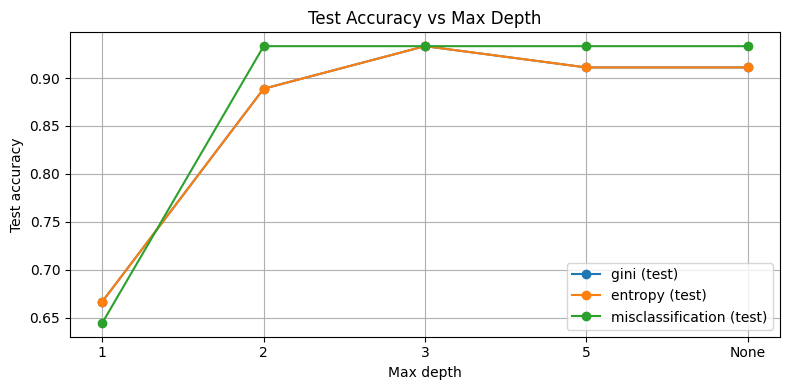

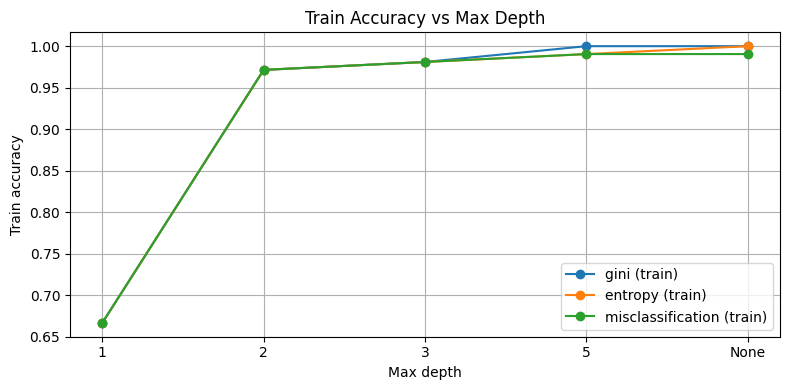

Best model by test accuracy: criterion=gini, max_depth=3
Confusion matrix (rows=true, cols=pred):
[[15  0  0]
 [ 0 14  1]
 [ 0  2 13]]
Class 0 (setosa): precision=1.000, recall=1.000, f1=1.000
Class 1 (versicolor): precision=0.875, recall=0.933, f1=0.903
Class 2 (virginica): precision=0.929, recall=0.867, f1=0.897


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

iris = load_iris()
X = iris['data']; y = iris['target']; feature_names = iris['feature_names']; target_names = iris['target_names']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y)

depths = [1,2,3,5,None]
criteria = ['gini','entropy','misclassification']

results = []
detailed = {}

for crit in criteria:
    detailed[crit] = {}
    for d in depths:
        clf = DecisionTreeClassifierScratch(criterion=crit, max_depth=d, min_samples_split=2)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        train_acc = accuracy_score_custom(y_train, y_pred_train)
        test_acc = accuracy_score_custom(y_test, y_pred_test)
        cm_test, labels = confusion_matrix_custom(y_test, y_pred_test, labels=np.unique(y))
        precision, recall, f1 = precision_recall_f1_from_cm(cm_test)
        report = {'criterion': crit, 'max_depth': d, 'train_acc': float(train_acc), 'test_acc': float(test_acc),
                  'confusion_matrix': cm_test.tolist(), 'labels': [int(x) for x in labels],
                  'precision_per_class': precision.tolist(), 'recall_per_class': recall.tolist(), 'f1_per_class': f1.tolist()}
        results.append({'criterion': crit, 'max_depth': 'None' if d is None else d,
                        'train_acc': float(train_acc), 'test_acc': float(test_acc),
                        'precision_macro': float(np.mean(precision)), 'recall_macro': float(np.mean(recall)), 'f1_macro': float(np.mean(f1))})
        detailed[crit][str(d)] = report

res_df = pd.DataFrame(results)

print('Results table (train/test accuracy and macro metrics):')
display(res_df[['criterion','max_depth','train_acc','test_acc','precision_macro','recall_macro','f1_macro']])

plot_dir = 'assignment_plots'
os.makedirs(plot_dir, exist_ok=True)
depth_labels = ['1','2','3','5','None']
x = np.arange(len(depth_labels))

plt.figure(figsize=(8,4))
for crit in criteria:
    vals = []
    for d in depths:
        row = res_df[(res_df['criterion']==crit) & (res_df['max_depth']==('None' if d is None else d))]
        vals.append(row['test_acc'].values[0] if len(row)>0 else np.nan)
    plt.plot(x, vals, marker='o', label=f"{crit} (test)")
plt.xticks(x, depth_labels); plt.xlabel('Max depth'); plt.ylabel('Test accuracy'); plt.title('Test Accuracy vs Max Depth'); plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
for crit in criteria:
    vals = []
    for d in depths:
        row = res_df[(res_df['criterion']==crit) & (res_df['max_depth']==('None' if d is None else d))]
        vals.append(row['train_acc'].values[0] if len(row)>0 else np.nan)
    plt.plot(x, vals, marker='o', label=f"{crit} (train)")
plt.xticks(x, depth_labels); plt.xlabel('Max depth'); plt.ylabel('Train accuracy'); plt.title('Train Accuracy vs Max Depth'); plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

best_row = res_df.loc[res_df['test_acc'].idxmax()]
best_crit = best_row['criterion']; best_depth = best_row['max_depth']
best_report = detailed[best_crit][str(None if best_depth=='None' else int(best_depth))]
print(f"Best model by test accuracy: criterion={best_crit}, max_depth={best_depth}")
print('Confusion matrix (rows=true, cols=pred):')
print(np.array(best_report['confusion_matrix']))
precision = best_report['precision_per_class']; recall = best_report['recall_per_class']; f1 = best_report['f1_per_class']
for i,lab in enumerate(best_report['labels']):
    print(f"Class {lab} ({target_names[lab]}): precision={precision[i]:.3f}, recall={recall[i]:.3f}, f1={f1[i]:.3f}")


***Conclusions***

Model choice: For this experimental setup, Decision Tree (Gini, max_depth=3) is a solid choice — interpretable and high-performing (≈93% test accuracy).

Complexity vs generalization: Increasing depth raises training accuracy; test accuracy plateaus and may slightly drop for very deep/unlimited trees due to overfitting. Depth 3 is a good trade-off between simplicity and performance.

Class-specific behavior: Perfect separation of setosa but small confusion between versicolor and virginica. If improving performance on those two classes matters, consider additional steps below.

**Key observations (best model)**

Best test accuracy: 93.33% (42 correct / 45 total).

Best model configuration: Gini impurity with max_depth = 3.

Confusion matrix (rows=true, cols=pred) for best model:

[[15, 0, 0],

 [ 0,14, 1],

 [ 0, 2,13]]

**3 total misclassifications** : 1 versicolor → virginica, 2 virginica → versicolor.

**Per-class metrics** (precision / recall / F1):

Class 0 (setosa): 1.000 / 1.000 / 1.000

Class 1 (versicolor): 0.875 / 0.933 / 0.903

Class 2 (virginica): 0.929 / 0.867 / 0.897

Macro averages: Precision ≈ 0.9345, Recall ≈ 0.9333, F1 ≈ 0.9333
